In [1]:
from coredldev.utilites.noise import (
    generate_colored_noise,
    get_time_domain_strain,
    get_frequency_domain_strain,
    to_pycbc_timeseries,
)
from coredldev._filepaths._filepaths import ligopsd_path
from coredldev.utilites._preprocessing import pad_width, window, planck_window
from coredldev.utilites.fastnoise import wavelet_transform as wt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import cupy as cp
gpus = list(range(cp.cuda.runtime.getDeviceCount()))
import multiprocessing
import gpuwthelper
multiprocessing.set_start_method("spawn")
window = lambda ts: planck_window(math.floor(math.log(len(ts) / 2) * 6), len(ts) + 2)
%matplotlib inline


/storage/home/cfa5403/miniconda3/envs/cuda11/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
def ts_noise(
    size=1000,
    sam_p=1 / (16392 * 8),
):
    fnoise = generate_colored_noise(
        psd_file=ligopsd_path,
        sampling_frequency=1 / sam_p,
        duration=size * sam_p,
    )
    tds = get_time_domain_strain(fnoise[0], sampling_frequency=1 / sam_p)
    return tds

In [3]:
gpus = list(range(cp.cuda.runtime.getDeviceCount()))
gpus

[0, 1]

In [4]:
mmap = np.memmap("""/storage/home/cfa5403/work/bnspmml/core_db_pytorch_dataloaders_system/coredldev/_resources/noisecache/noise.npy""", dtype=np.float64, mode="w+", shape=(400, 40 * 10**6))

In [5]:
mmap.shape[1]/50000

800.0

In [6]:
for i in range(100):
    pool = gpuwthelper.Parallel(len(gpus))
    ps = [{"X": ts_noise(20*10**4), "gpu": True, "device": i} for i in gpus]
    a = pool.process(gpuwthelper.wthelper, ps)
    pool.close()
    mmap[:, i*200000:(i+1)*200000] = a[0]
    mmap[:, i*200000 + 200000:(i+1)*200000+200000] = a[1]
    print(f"done with {i}")

done with 0
done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done with 13
done with 14
done with 15
done with 16
done with 17
done with 18
done with 19
done with 20
done with 21
done with 22
done with 23
done with 24
done with 25
done with 26
done with 27
done with 28
done with 29
done with 30
done with 31
done with 32
done with 33
done with 34
done with 35
done with 36
done with 37
done with 38
done with 39
done with 40
done with 41
done with 42
done with 43
done with 44
done with 45
done with 46
done with 47
done with 48
done with 49
done with 50
done with 51
done with 52
done with 53
done with 54
done with 55
done with 56
done with 57
done with 58
done with 59
done with 60
done with 61
done with 62
done with 63
done with 64
done with 65
done with 66
done with 67
done with 68
done with 69
done with 70
done with 71
done with 72
done with 73
done with 74
done with 75
done with 76
done with

In [10]:
import matplotlib.pyplot as plt

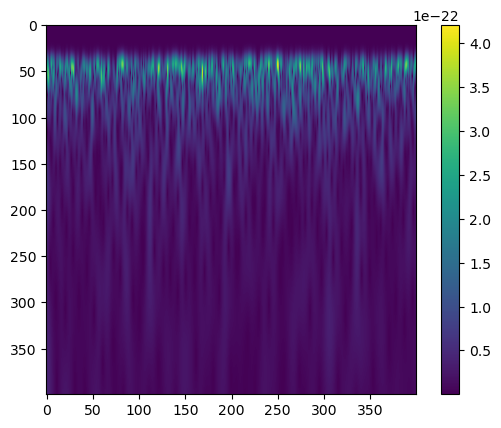

In [11]:
plt.imshow(mmap[:, 0:20000:50],)
plt.colorbar()
plt.show()

In [9]:
mmap.shape

(400, 40000000)